# Application of Linear Models in Multivariate Time Series Analysis
---
Why Linear Models?
- Most time series models, like SARIMA, demands too much time for data preparation.
- ARIMA family of models also require frequent retraining on new datasets.
- Better use linear models which do not require frequent retraining and are eaily deployable with minor data preparation.
Note:
- This approach is not backed by theory and breaks several assumptions (e.g. Gauss-Markov theorem, especially for errors being uncorrelated), but it is very useful in practice and is often used in machine learning competitions.

# Situation:
There is a boom in crypto-related games such as Axie Infinity where there is an exchange (buy and sell) of LPS. In this exercise we will analyzing NFT's and Virtual Currencies in Games, particulary when are people willing to spend gems.

In [9]:
import plotly.graph_objects as go
from datetime import timedelta, date
import warnings                                  # Removes warning
warnings.filterwarnings('ignore')

import numpy as np                               # vectors and matrices
import pandas as pd                              # tables and data manipulations
import matplotlib.pyplot as plt                  # plots
import seaborn as sns                            # plots

from dateutil.relativedelta import relativedelta # working with dates with style
from scipy.optimize import minimize              # for function minimization

import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product                    # some useful functions
from tqdm import tqdm_notebook

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error,mean_squared_error

%matplotlib inline

In [10]:
currency = pd.read_csv('games.csv', index_col=['Time'], parse_dates=['Time'])
currency.tail(5)

,GEMS_GEMS_SPENT
Time,
2018-02-20,2166449
2018-02-21,1552313
2018-02-22,2175548
2018-02-23,2122606
2018-02-24,1756394


# Errors as Performance Metrics of Linear Models:
- Error = True - Predicted
- Absolute Error = |Error|
- a. r2_score - the percentage of variance explained by the model.
- b. median_absolute_error - the middle value of the absolute errors.
- c. mean_absolute_error - the average value of the absolute errors.
- d. mean_squared_error - Variance + Bias, gives a higher penalty to large errors.

# The Lags of TS
- Features can be obtained by shifting the TS data n steps back:
    - A lag of 1 day (yesterday) will develop a model that will predict tomorrow.
    - A lag of 6 days (6 days ago) will develop a model that will predict 6 days forward.
    
- Note:
        - If a sudden change (called a random shock) is not observed during the lagging process, the model will not catch these changes.
        - Erroneous Results.
        - Initial lag selection shoulbe be a balance between the optimal prediction quality and the length of the forecast horizon.

In [11]:
data = pd.DataFrame(currency.GEMS_GEMS_SPENT.copy())
data.columns = ["y"]

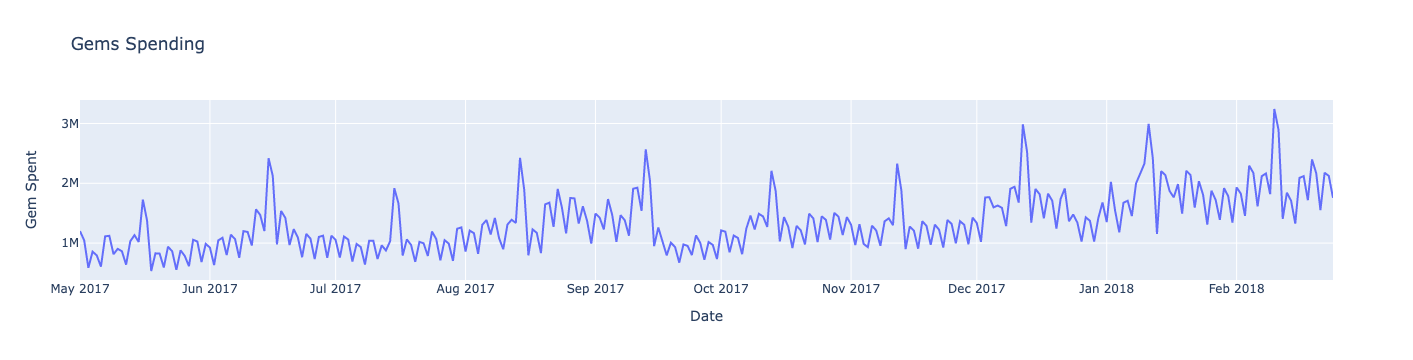

In [12]:
# Tell plotly you want to create a figure
fig = go.Figure()
# Add a trace, and tell plotly.graph_objects you want to create a line chart
fig.add_trace(go.Scatter(x=data.index, y=data['y']))
# Update the layout
fig.update_layout(title='Gems Spending',
                   xaxis_title='Date',
                   yaxis_title='Gem Spent')
fig.show()

In [13]:
# Adding the lag of the target variable from 6 steps back up to 24
for i in range(6, 25):
    data["lag_{}".format(i)] = data.y.shift(i)

In [14]:
data.head(30)

,y,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24
Time,,,,,,,,,,,,,,,,,,,,
2017-05-01,1199436,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-05-02,1045515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-05-03,586111,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-05-04,856601,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-05-05,793775,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-05-06,606535,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-05-07,1112763,1199436.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-05-08,1121218,1045515.0,1199436.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-05-09,813844,586111.0,1045515.0,1199436.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


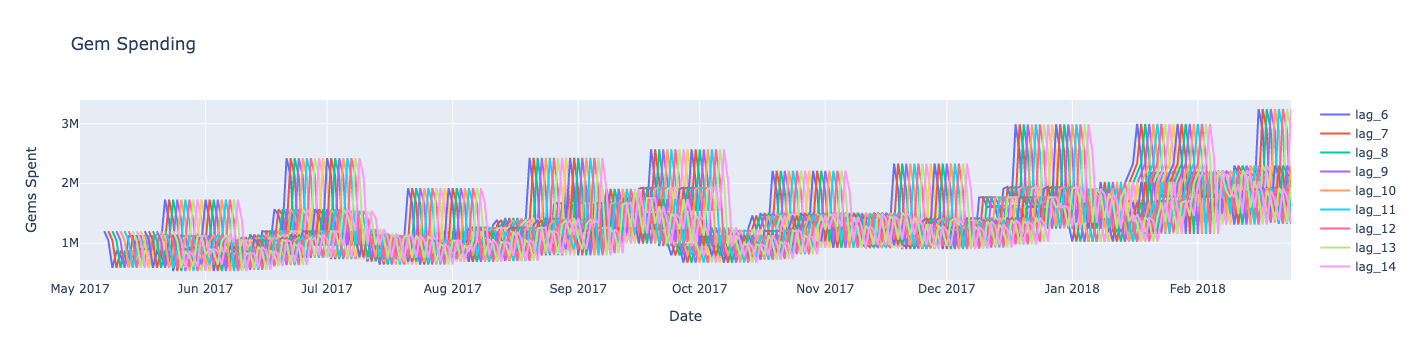

In [15]:
# Tell plotly you want to create a figure
fig = go.Figure()
# Go through every unique columns
for i in range(6, 25):
    # Add a trace, and tell plotly.graph_objects you want to create a line chart
    fig.add_trace(go.Scatter(x=data.index, y=data["lag_{}".format(i)],name = str("lag_{}".format(i)),mode = 'lines'))

# Update the layout
fig.update_layout(title='Gem Spending',
                   xaxis_title='Date',
                   yaxis_title='Gems Spent')
fig.show()

In [16]:
from sklearn.model_selection import TimeSeriesSplit
# for time-series cross-validation set 10 folds 
tscv = TimeSeriesSplit(n_splits=10)

In [17]:
def timeseries_train_test_split(X, y, test_size):
    """
        Perform train-test split with respect to time series structure
    """
    
    # get the index after which test set starts
    test_index = int(len(X)*(1-test_size))
    
    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]
    
    return X_train, X_test, y_train, y_test

In [18]:
y = data.dropna().y
X = data.dropna().drop(['y'], axis=1)

# reserve 30% of data for testing
X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)

In [19]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [20]:
def plotModelResults(model, X_train=X_train, X_test=X_test, plot_intervals=False, plot_anomalies=False):
    """
        Plots modelled vs fact values, prediction intervals and anomalies
    
    """
    
    prediction = model.predict(X_test)
    
    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)
    
    if plot_intervals:
        cv = cross_val_score(model, X_train, y_train, 
                                    cv=tscv, 
                                    scoring="neg_mean_absolute_error")
        mae = cv.mean() * (-1)
        deviation = cv.std()
        
        scale = 1.96
        lower = prediction - (mae + scale * deviation)
        upper = prediction + (mae + scale * deviation)
        
        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)
        
        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(y_test))
            anomalies[y_test<lower] = y_test[y_test<lower]
            anomalies[y_test>upper] = y_test[y_test>upper]
            plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    error = mean_absolute_percentage_error(prediction, y_test)
    plt.title("Mean absolute percentage error {0:.2f}%".format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);
    
    
def plotCoefficients(model):
    """
        Plots sorted coefficient values of the model
    """
    
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    
    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');

    
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

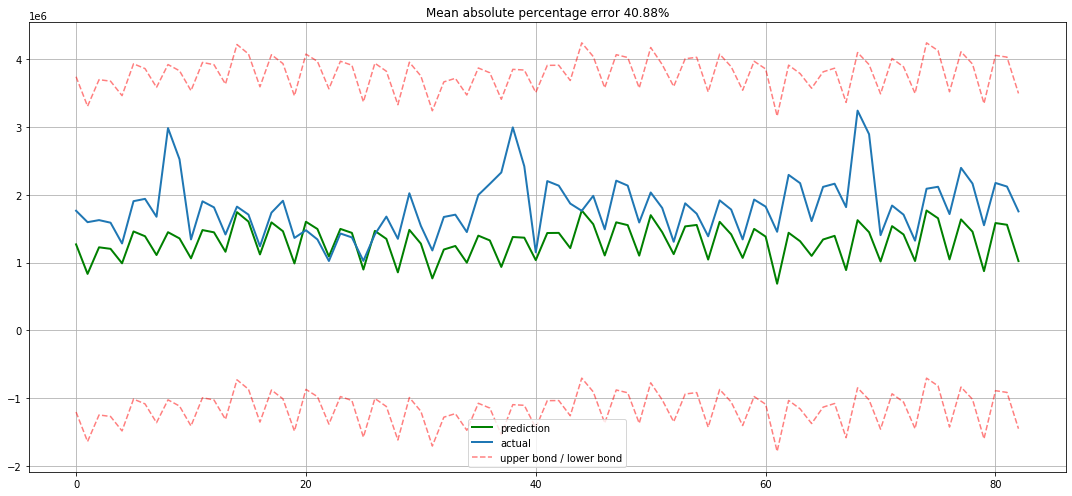

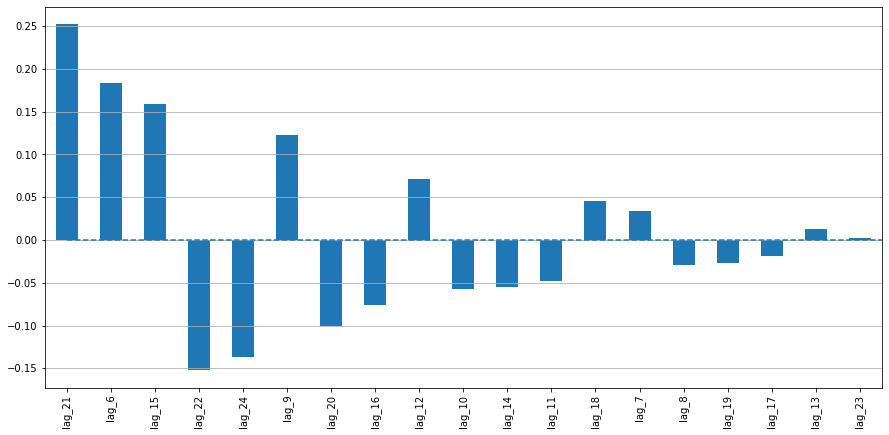

In [21]:
plotModelResults(lr, plot_intervals=True)
plotCoefficients(lr)

In [22]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

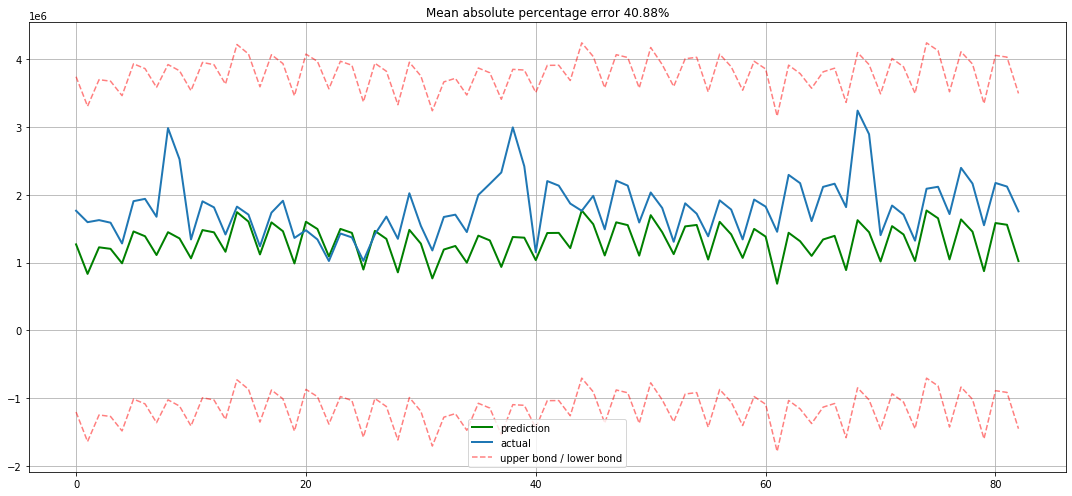

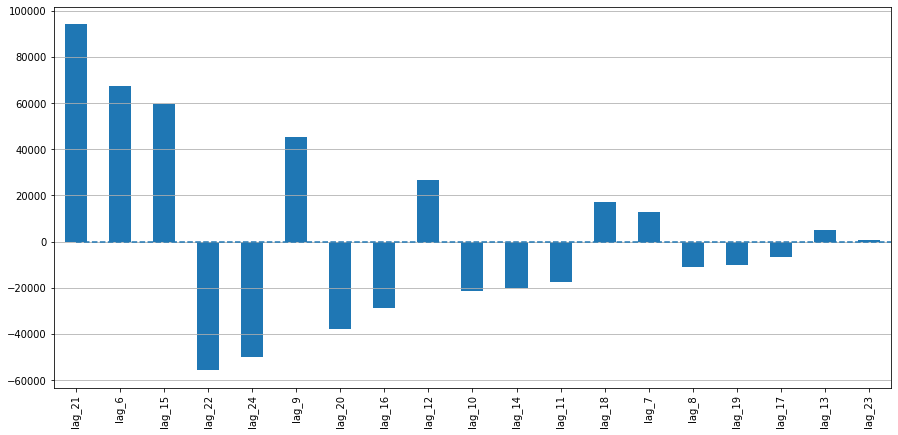

In [23]:
y = data.dropna().y
X = data.dropna().drop(['y'], axis=1)

X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

plotModelResults(lr, X_train=X_train_scaled, X_test=X_test_scaled, plot_intervals=True)
plotCoefficients(lr)

# Lasso Regression and Ridge Regression
---
- Capable of regularization and feature selection.
- We do not need the entier features, some may lead to overfitting while others should be removed.
- Manual inspection using plots. 
- Apply regularization.

Ridge regression: (L2 Norm)
- The bigger the coefficient a feature has, the bigger the penalty for that feature. 
- Goal: Optimize the model while keeping the coefficients low.
- Higher bias but lower variance.
- Better Generalization.

Lasso regression:(L1 Norm)
- Coefficients of unimportant features are penalized to zeroes, which allows for automated feature selection

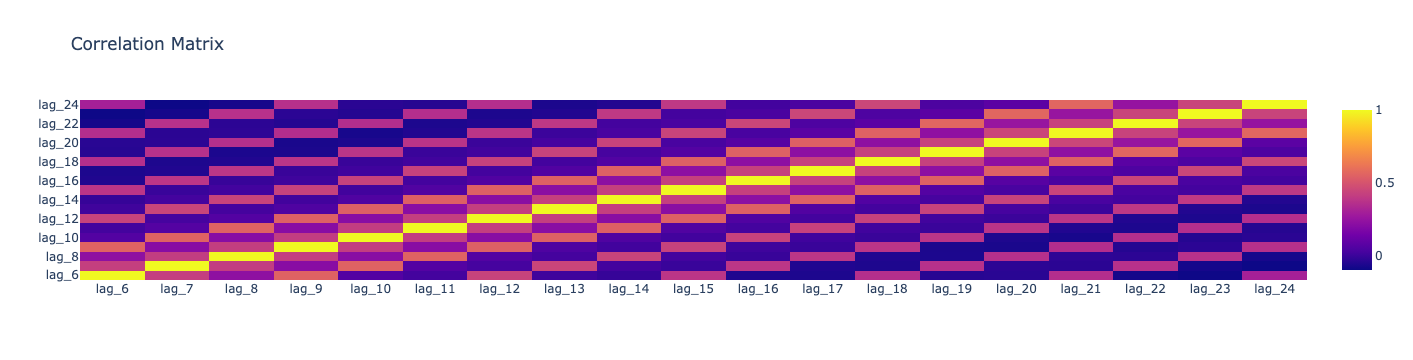

In [24]:
corr = X_train.corr()
import plotly.graph_objects as go

fig = go.Figure(go.Heatmap(z=corr.values,
                  x=corr.index.values,
                  y=corr.columns.values))
fig.update_layout(title = "Correlation Matrix")
fig.show()

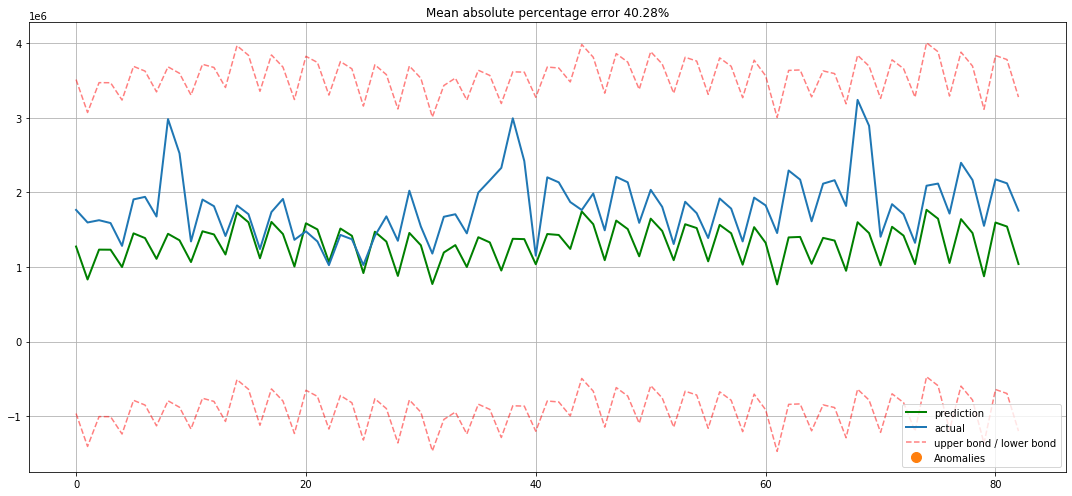

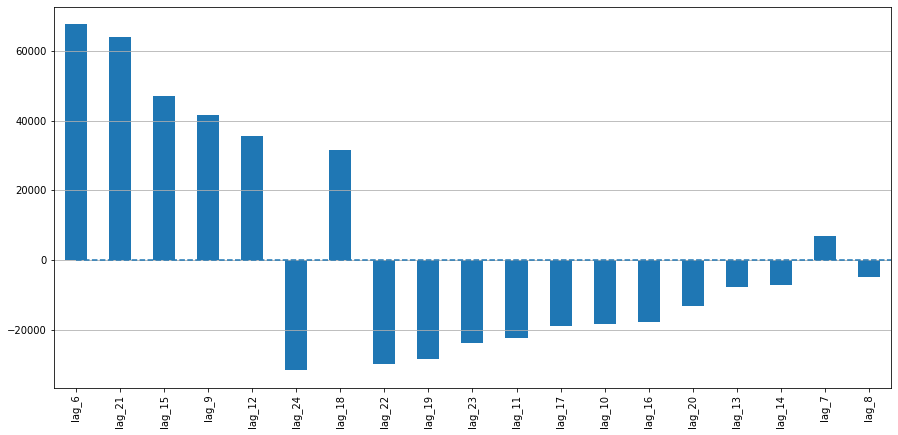

In [25]:
from sklearn.linear_model import LassoCV, RidgeCV

ridge = RidgeCV(cv=tscv)
ridge.fit(X_train_scaled, y_train)

plotModelResults(ridge, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 plot_intervals=True, plot_anomalies=True)
plotCoefficients(ridge)

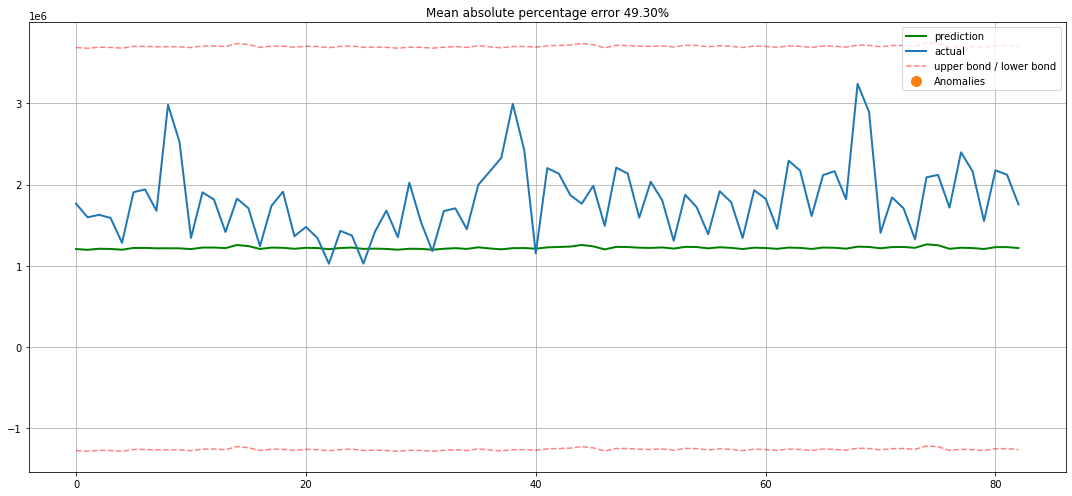

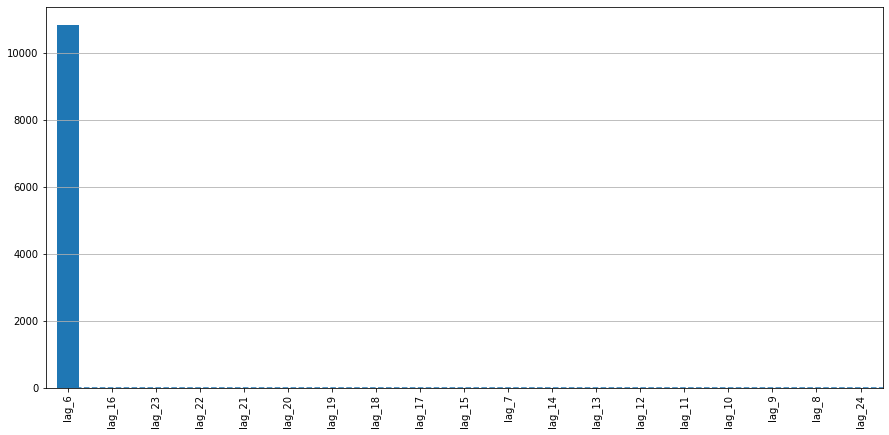

In [26]:
lasso = LassoCV(cv=tscv)
lasso.fit(X_train_scaled, y_train)

plotModelResults(lasso, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 plot_intervals=True, plot_anomalies=True)
plotCoefficients(lasso)

Lasso regression turned out to be more conservative; Dropped the entire features except for Lag 6

# Elastic Net
- Combination of Ridge and LASSO (L1 and L2 Norm)

In [27]:
from sklearn.linear_model import ElasticNetCV

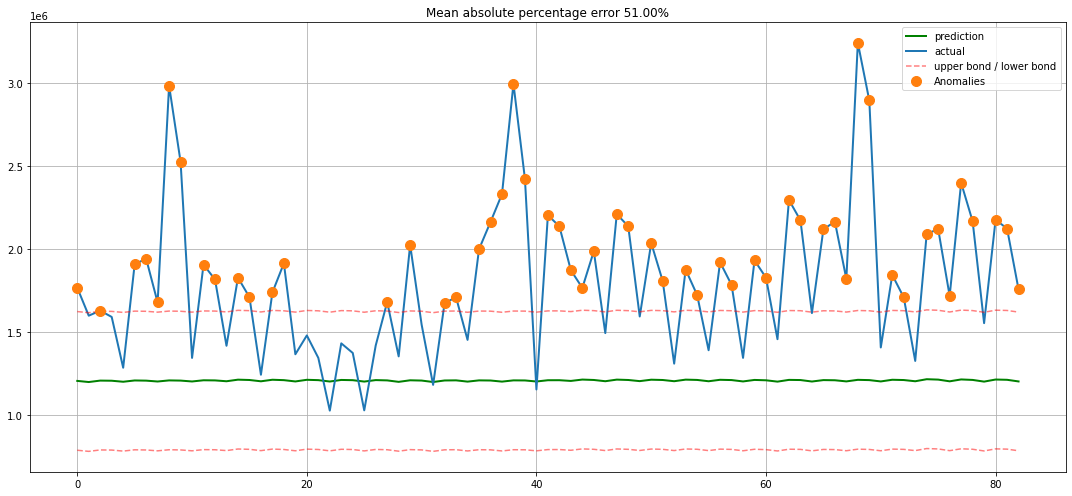

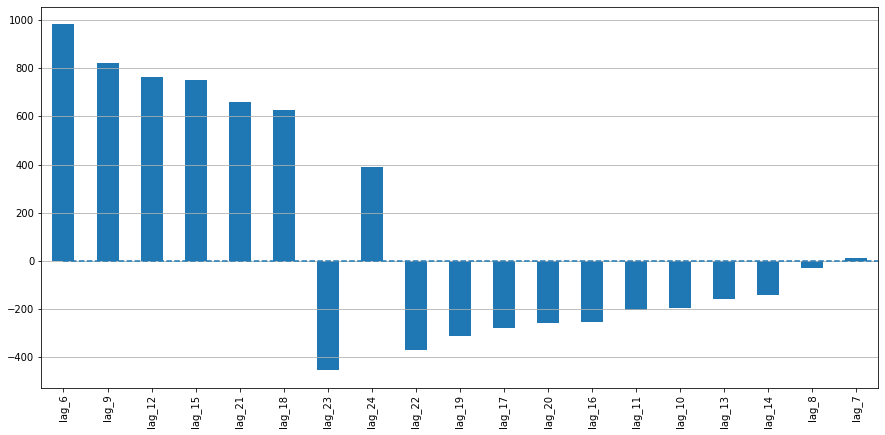

In [28]:
elastic = ElasticNetCV(cv=tscv)
elastic.fit(X_train_scaled, y_train)

plotModelResults(elastic, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 plot_intervals=True, plot_anomalies=True)
plotCoefficients(elastic)